In [ ]:
import pandas as pd
import numpy as np
import miceforest as mf
import seaborn as sns
import matplotlib.pyplot as plt

# Data Imputation Methods

Considering the number of missing values found within the dataset a variety of imputation methods were considered to take care of data sparsity. To address this, key features of the data set were considered including the fact that feetures are highly correlated in addition to whether the data is missing at random, missing completley at random, or missing not at random. 

Missing Completely at Random, MCAR, means there is no relationship between the missingness of the data and any values, observed or missing. Those missing data points are a random subset of the data. There is nothing systematic going on that makes some data more likely to be missing than others.

Missing at Random, MAR, means there is a systematic relationship between the propensity of missing values and the observed data, but not the missing data. Whether an observation is missing has nothing to do with the missing values, but it does have to do with the values of an individual’s observed variables. So, for example, if men are more likely to tell you their weight than women, weight is MAR.

Missing Not at Random, MNAR, means there is a relationship between the propensity of a value to be missing and its values. This is a case where the people with the lowest education are missing on education or the sickest people are most likely to drop out of the study.

## Quick Note:
To get more accurate results Text Data must be Cleaned First by dealing with Typos in Text Data (Counties).

## Identifying Features with missing data and conduct exploratory analysis in relation to the missing data to identify how to address data sparsity

In [2]:
dfdict = pd.read_excel("../../data/DataDictionary.xlsx")

#rename field
dfdict= dfdict.rename(columns={'Field Type': 'field_type','Field Name':'Feature'})
dfdict.field_type = dfdict.field_type.astype(str)

#remove field not in novice
dfdict=dfdict.drop(index=[1,2]).reset_index(drop=True)
#dfdict.reset_index(drop=True)
dfdict.head()

,Field ID,Feature,Short Description,Long Description,field_type,Additional Notes
0,1,Match ID 18Char,Unique ID for each Big/Little Match,A unique identifier for each Big/Little match,ID,NaN
1,4,Stage,Match status,Match status as of 2025-02-27,Categorical,This field deleted from test set
2,5,Little ID,Little's Unique ID,A unique identifier for each Little,ID,NaN
3,6,Big ID,Big's Unique ID,A unique identifier for each Big,ID,NaN
4,7,Big County,County of the Big,County of the Big at time of Match,Text,NaN


In [3]:

ogdf = pd.read_excel("../../data/Novice.xlsx") #load novice data

df=ogdf.copy()

In [4]:
df.isna().sum() #count number of NaN values per column

Match ID 18Char                                 0
Stage                                           0
Little ID                                       0
Big ID                                          0
Big County                                    655
                                             ... 
Little Birthdate                                0
Little Mailing Address Census Block Group     966
Big Home Census Block Group                  1005
Big Employer/School Census Block Group       3158
Match Length                                    0
Length: 66, dtype: int64

In [5]:
df.nunique() #count the number of unique values

Match ID 18Char                              3275
Stage                                           3
Little ID                                    2998
Big ID                                       3080
Big County                                     54
                                             ... 
Little Birthdate                              165
Little Mailing Address Census Block Group     959
Big Home Census Block Group                  1163
Big Employer/School Census Block Group         91
Match Length                                  701
Length: 66, dtype: int64

In [6]:
#Calculate the percent of missing values
percent_missing = df.isnull().sum() * 100 / len(df)

percent_missing =pd.DataFrame({'Feature':percent_missing.index,'prcnt_missing':percent_missing})
percent_missing.reset_index(drop=True)

,Feature,prcnt_missing
0,Match ID 18Char,0.000000
1,Stage,0.000000
2,Little ID,0.000000
3,Big ID,0.000000
4,Big County,20.000000
...,...,...
61,Little Birthdate,0.000000
62,Little Mailing Address Census Block Group,29.496183
63,Big Home Census Block Group,30.687023
64,Big Employer/School Census Block Group,96.427481


In [7]:
percent_missing = pd.merge(percent_missing, dfdict,on='Feature')
percent_missing =percent_missing.drop(columns=['Field ID','Short Description','Long Description','Additional Notes'])
percent_missing

,Feature,prcnt_missing,field_type
0,Match ID 18Char,0.000000,ID
1,Stage,0.000000,Categorical
2,Little ID,0.000000,ID
3,Big ID,0.000000,ID
4,Big County,20.000000,Text
...,...,...,...
60,Little Birthdate,0.000000,Date
61,Little Mailing Address Census Block Group,29.496183,ID
62,Big Home Census Block Group,30.687023,ID
63,Big Employer/School Census Block Group,96.427481,ID


In [8]:
#non-missing features
percent_missing[percent_missing.prcnt_missing==0]

,Feature,prcnt_missing,field_type
0,Match ID 18Char,0.0,ID
1,Stage,0.0,Categorical
2,Little ID,0.0,ID
3,Big ID,0.0,ID
5,Big Age,0.0,Numerical
11,Big Birthdate,0.0,Date
13,Program,0.0,Text
14,Program Type,0.0,Categorical
18,Match Activation Date,0.0,Date
60,Little Birthdate,0.0,Date


In [9]:

#Identify number of features with Missing Data
missing=percent_missing[percent_missing.prcnt_missing!=0].reset_index(drop=True)
missing.head()

,Feature,prcnt_missing,field_type
0,Big County,20.000000,Text
1,Big Occupation,9.923664,Categorical
2,Big Approved Date,8.885496,Categorical
3,Big Level of Education,86.259542,Categorical
4,Big Languages,46.167939,"Categorical, List"


In [10]:
#report the number of unique values for each missing feature and sort from lowest to highest percent missing
nuniq=[]
nmiss=[]
for i in missing.Feature:
    nuniq.append(df[i].nunique())  
    nmiss.append(df[i].isna().sum())
missing['nuniq']=nuniq
missing['nmissing']=nmiss
missing.sort_values(by=['prcnt_missing'],ascending=False)

,Feature,prcnt_missing,field_type,nuniq,nmissing
23,Big Contact: Interest Finder - Sports,99.175573,"Categorical, List",23,3248
26,Big Contact: Interest Finder - Entertainment,99.175573,"Categorical, List",20,3248
24,Big Contact: Interest Finder - Places To Go,99.175573,"Categorical, List",11,3248
25,Big Contact: Interest Finder - Hobbies,99.175573,"Categorical, List",22,3248
44,Little Contact: Interest Finder - Other Interests,99.022901,Text,20,3243
19,Big Open to Cross-Gender Match,98.870229,Categorical,2,3238
35,Little Contact: Language(s) Spoken,98.839695,"Categorical, List",3,3237
22,Big Contact: Former Big/Little,98.045802,Categorical,2,3211
48,Little Contact: Interest Finder - Three Wishes,97.801527,Text,41,3203
46,Little Contact: Interest Finder - Career,97.801527,Text,41,3203


In [11]:
table = pd.pivot_table(missing, values=['nmissing'], index=['field_type'], aggfunc="sum")
table

,nmissing
field_type,
Categorical,22747
"Categorical, List",43243
Date,22705
ID,5129
Numerical,6725
Text,15504


In [12]:
table = pd.pivot_table(missing, values=['prcnt_missing'], index=['field_type'], aggfunc="median")
table

,prcnt_missing
field_type,
Categorical,58.961832
"Categorical, List",97.557252
Date,58.137405
ID,30.687023
Numerical,73.618321
Text,66.412214


In [13]:
### Data Imputation across Different Data Types

##### Text Data: (Not Specified)
1. County -> use info on census group
2. Employer -> Not specified?
3. Closure Details/Closure Reason -> Not Specified
4. Rationale for Match -> Not Specified
5. Combine last four in little interest column

In [14]:
missing[missing["field_type"] == 'Text']

,Feature,prcnt_missing,field_type,nuniq,nmissing
0,Big County,20.000000,Text,54,655
6,Big Employer,16.824427,Text,1624,551
9,Closure Details,42.473282,Text,1756,1391
11,Rationale for Match,9.129771,Text,2803,299
44,Little Contact: Interest Finder - Other Interests,99.022901,Text,20,3243
45,Little Other Interests,90.351145,Text,276,2959
46,Little Contact: Interest Finder - Career,97.801527,Text,41,3203
48,Little Contact: Interest Finder - Three Wishes,97.801527,Text,41,3203


##### Categorical

In [15]:
missing[missing["field_type"] == 'Categorical']


,Feature,prcnt_missing,field_type,nuniq,nmissing
1,Big Occupation,9.923664,Categorical,87,325
2,Big Approved Date,8.885496,Categorical,1238,291
3,Big Level of Education,86.259542,Categorical,9,2825
5,Big Gender,0.030534,Categorical,6,1
8,Closure Reason,24.000000,Categorical,33,786
12,Big Enrollment: Record Type,58.076336,Categorical,5,1902
15,Big Car Access,96.427481,Categorical,3,3158
19,Big Open to Cross-Gender Match,98.870229,Categorical,2,3238
20,Big Re-Enroll,58.076336,Categorical,2,1902
21,Big Contact: Preferred Communication Type,96.122137,Categorical,3,3148


##### Date

In [16]:
missing[missing["field_type"] == 'Date']

,Feature,prcnt_missing,field_type,nuniq,nmissing
10,Match Closure Meeting Date,77.679389,Date,451,2544
13,Big Assessment Uploaded,58.106870,Date,816,1903
14,Big Acceptance Date,58.106870,Date,712,1903
27,Big Contact: Created Date,58.076336,Date,860,1902
28,Big Enrollment: Created Date,58.076336,Date,777,1902
31,Little RTBM Date in MF,92.427481,Date,112,3027
32,Little RTBM in Matchforce,58.137405,Date,2,1904
33,Little Moved to RTBM in MF,58.137405,Date,1,1904
34,Little Application Received,58.137405,Date,766,1904
36,Little Interview Date,58.229008,Date,731,1907


##### ID

In [17]:
missing[missing["field_type"] == 'ID']

,Feature,prcnt_missing,field_type,nuniq,nmissing
51,Little Mailing Address Census Block Group,29.496183,ID,959,966
52,Big Home Census Block Group,30.687023,ID,1163,1005
53,Big Employer/School Census Block Group,96.427481,ID,91,3158


##### Categorical List
1. Combine interests into column
2. use both language and ethnicity to impute each other
3. impute little race/ethnicity from little contaxt languages spoken 
4. impute gender

In [18]:
missing[missing["field_type"] == 'Categorical, List']

,Feature,prcnt_missing,field_type,nuniq,nmissing
4,Big Languages,46.167939,"Categorical, List",29,1512
7,Big Race/Ethnicity,1.007634,"Categorical, List",20,33
23,Big Contact: Interest Finder - Sports,99.175573,"Categorical, List",23,3248
24,Big Contact: Interest Finder - Places To Go,99.175573,"Categorical, List",11,3248
25,Big Contact: Interest Finder - Hobbies,99.175573,"Categorical, List",22,3248
26,Big Contact: Interest Finder - Entertainment,99.175573,"Categorical, List",20,3248
29,Big Contact: Volunteer Availability,91.541985,"Categorical, List",13,2998
35,Little Contact: Language(s) Spoken,98.839695,"Categorical, List",3,3237
38,Little Contact: Interest Finder - Sports,97.557252,"Categorical, List",46,3195
39,Little Contact: Interest Finder - Outdoors,97.557252,"Categorical, List",41,3195


##### Numerical

In [19]:
missing[missing["field_type"] == 'Numerical']

,Feature,prcnt_missing,field_type,nuniq,nmissing
16,Big Days Acceptance to Match,73.618321,Numerical,266,2411
17,Big Days Interview to Acceptance,58.106870,Numerical,173,1903
18,Big Days Interview to Match,73.618321,Numerical,306,2411


## Addressing Missing Data

### STEPS IN DEALING WITH MISSING DATA
0. Drop irrelevant columns
- Drop any columns that are not important for modeling
1. Data Cleaning
- Receode Missingnes
- Check if any missing values can be computed through other values (i.e. county from census code)
- Label missing Text data as missing
2. Imputational Methods:
- Convert Data to Categorical or Numerical
- Perform MICE
- plot distributions of imputed data to assess effectiveness

#### 0. Drop Irrelevant Missing Columns

In [20]:
#Non-Missing Columns
# note: Convert Program to Categorical variable and use date,Categorical,and numerical to impute (remove ID for data imputation)

# Match ID
# Stage	- Categorical
# Little ID
# Big ID
# Big Age
# Big Birthdate
# Program -	Text
# Program Type -Categorical
# Match Activation Date	- Date
# Little Birthdate	- 	Date
# Match Length	-	Numerical


#Missing Columns
# drop irrelevant text fields
# 	NOT DROPPED: Big County, Rationale for Match
#note: clean county prior to imputing missing data
# fill Rationale for Match missing values with "missing" and remove for data imputation
df=df.drop(columns=["Big Employer","Closure Details"])


#drop interest finder fields
df=df.drop(columns=["Big Contact: Interest Finder - Entertainment","Big Contact: Interest Finder - Hobbies","Big Contact: Interest Finder - Places To Go",
                    "Big Contact: Interest Finder - Sports","Little Contact: Interest Finder - Arts","Little Contact: Interest Finder - Career",
                    "Little Contact: Interest Finder - Entertainment", "Little Contact: Interest Finder - Hobbies", "Little Contact: Interest Finder - Other Interests",
                    "Little Contact: Interest Finder - Outdoors","Little Contact: Interest Finder - Personality","Little Contact: Interest Finder - Places To Go",
                    "Little Contact: Interest Finder - Sports","Little Contact: Interest Finder - Three Wishes","Little Other Interests",
                    ])

#drop irrelevant categorical fields
# NOT DROPPED:  Big Occupation, Big Gender, Big Contact: Marital Status, Closure Reason

df=df.drop(columns=["Big Level of Education",'Big Enrollment: Record Type',"Big Car Access", "Big Open to Cross-Gender Match", "Big Re-Enroll", 
                    "Big Contact: Preferred Communication Type", "Big Contact: Former Big/Little","Big Approved Date","Big: Military"])


#drop irrelevant dates
# NOT DROPPED: 
# note: create Match Closure Date which is computed from the Match length

df=df.drop(columns=["Big Assessment Uploaded","Big Acceptance Date","Big Contact: Created Date","Big Enrollment: Created Date",
                    "Little RTBM Date in MF","Little RTBM in Matchforce","Little Moved to RTBM in MF","Little Application Received","Little Interview Date",
                    "Little Acceptance Date","Match Closure Meeting Date"])

#drop irrelevant IDs
# NOT DROPPED: Little Mailing Address Census Block Group (convert to little county then drop)
# NOT DROPPED: "Big Home Census Block Group" (use to fill missing county values then remove)

df=df.drop(columns=["Big Employer/School Census Block Group"])

#drop irrelevant categorical lists
# NOT DROPPED: Big Languages,Big Race/Ethnicity,Little Gender

df=df.drop(columns=["Big Contact: Volunteer Availability", "Little Contact: Language(s) Spoken"])

#drop irrelevant numerical  fields
# Not Dropped: Days Acceptance to Match,Big Days Interview to Acceptance,Big Days Interview to Match


# FOR NOW DROP GEOGRAPHICAL MARKERS
df=df.drop(columns=["Big County","Little Mailing Address Census Block Group","Big Home Census Block Group"])

pd.options.display.max_columns = None
df.head()


,Match ID 18Char,Stage,Little ID,Big ID,Big Age,Big Occupation,Big Languages,Big Gender,Big Birthdate,Program,Program Type,Big Race/Ethnicity,Closure Reason,Match Activation Date,Rationale for Match,Big Days Acceptance to Match,Big Days Interview to Acceptance,Big Days Interview to Match,Big Contact: Marital Status,Little Gender,Little Participant: Race/Ethnicity,Little Birthdate,Match Length
0,a1v2J0000028pRvQAI,Closed,0032J00003PLe29QAD,0032J00003PhDOI,40,Unemployed,No Preference,Female,1985-02-01,General Community,Community,Black or African American;White or Caucasian;,Volunteer: Health,2017-03-03,NaN,NaN,NaN,NaN,NaN,Female,Black or African American,2004-01-01,9.0
1,a1v2J000002uR0JQAU,Closed,0032J00003PfZ6OQAV,0032J00003PgoV1,65,Tech: Research/Design,No Preference,Female,1959-05-01,General Community,Community,White or Caucasian;,Child/Family: Feels incompatible with volunteer,2018-04-12,Their shared interests include spending time o...,NaN,NaN,NaN,NaN,Female,Black or African American; White or Caucasian,2006-06-01,46.1
2,a1v2J0000027NsOQAU,Closed,0032J00003PLeoRQAT,0032J00003Ph0MT,45,Military,Chinese,Male,1979-07-01,General Community,Community,Asian;,Volunteer: Moved,2017-03-23,NaN,NaN,NaN,NaN,NaN,Male,Black or African American; White or Caucasian,2007-01-01,6.2
3,a1v2J0000027dtOQAQ,Active,0032J00003PLeoRQAT,0032J00003Ph14N,61,Finance: Banking,No Preference,Male,1963-11-01,General Community,Community,White or Caucasian;,NaN,2018-01-11,B_first_name and L_first_name were matched bec...,NaN,NaN,NaN,NaN,Male,Black or African American; White or Caucasian,2007-01-01,85.6
4,a1v2J0000028enKQAQ,Closed,0032J00003PfZ6QQAV,0032J00003Ph14j,29,Human Services: Non-Profit,No Preference,Female,1996-01-01,General Community,Community,White or Caucasian;,Child/Family: Moved,2018-04-13,Shared interests like being creative and tryin...,NaN,NaN,NaN,NaN,Female,Hispanic,2005-01-01,28.3


#### 1. Data Cleaning

##### TEXT DATA
Rationale for Match: Convert all NaN values to "Not Specified"

In [21]:
#Do after imputing

Big County: Clean County Column (Complete Later)

In [22]:
#all unique county inputs
# df["Big County"].unique()


In [23]:
#fix spelling/format errors
# df = df.replace(to_replace=['Hennepin County','Henepin','Hennpin'],value='Hennepin')
# df = df.replace(to_replace=['St. Croix County, WI', 'St. Croix County'],value='St. Croix')
# df = df.replace('New Castle County','New Castle')
# df = df.replace('Ramesy','Ramsey')
# df = df.replace('Rice County','Rice')
# df = df.replace(to_replace=['St. Croix County, WI', 'St. Croix County'],value='St. Croix')


# #remove invalid counties
# invalid_counties=['Testing County', 'MN', 'Outside state', 'mn', 'US', 'United States',
#        'United States of America', 'California', 'Other']

# df = df.replace(to_replace=invalid_counties,value=np.nan)

# df["Big County"].unique()



In [24]:
# LATER Compute missing counties from census code
# import requests
# import csv

# def getCounties():
#     "Function to return a dict of FIPS codes (keys) of U.S. counties (values)"
#     d = {}
#     r = requests.get("http://www2.census.gov/geo/docs/reference/codes/files/national_county.txt")
#     reader = csv.reader(r.text.splitlines(), delimiter=',')    
#     for line in reader:
#         d[line[1] + line[2]] = line[3].replace(" County","")    
#     return d


##### CATEGORICAL DATA

Closure Reason: If a match is Active write "Still Active"

In [25]:

df.loc[df['Stage'] == 'Active', 'Closure Reason'] = 'Still Active'

df.head()


,Match ID 18Char,Stage,Little ID,Big ID,Big Age,Big Occupation,Big Languages,Big Gender,Big Birthdate,Program,Program Type,Big Race/Ethnicity,Closure Reason,Match Activation Date,Rationale for Match,Big Days Acceptance to Match,Big Days Interview to Acceptance,Big Days Interview to Match,Big Contact: Marital Status,Little Gender,Little Participant: Race/Ethnicity,Little Birthdate,Match Length
0,a1v2J0000028pRvQAI,Closed,0032J00003PLe29QAD,0032J00003PhDOI,40,Unemployed,No Preference,Female,1985-02-01,General Community,Community,Black or African American;White or Caucasian;,Volunteer: Health,2017-03-03,NaN,NaN,NaN,NaN,NaN,Female,Black or African American,2004-01-01,9.0
1,a1v2J000002uR0JQAU,Closed,0032J00003PfZ6OQAV,0032J00003PgoV1,65,Tech: Research/Design,No Preference,Female,1959-05-01,General Community,Community,White or Caucasian;,Child/Family: Feels incompatible with volunteer,2018-04-12,Their shared interests include spending time o...,NaN,NaN,NaN,NaN,Female,Black or African American; White or Caucasian,2006-06-01,46.1
2,a1v2J0000027NsOQAU,Closed,0032J00003PLeoRQAT,0032J00003Ph0MT,45,Military,Chinese,Male,1979-07-01,General Community,Community,Asian;,Volunteer: Moved,2017-03-23,NaN,NaN,NaN,NaN,NaN,Male,Black or African American; White or Caucasian,2007-01-01,6.2
3,a1v2J0000027dtOQAQ,Active,0032J00003PLeoRQAT,0032J00003Ph14N,61,Finance: Banking,No Preference,Male,1963-11-01,General Community,Community,White or Caucasian;,Still Active,2018-01-11,B_first_name and L_first_name were matched bec...,NaN,NaN,NaN,NaN,Male,Black or African American; White or Caucasian,2007-01-01,85.6
4,a1v2J0000028enKQAQ,Closed,0032J00003PfZ6QQAV,0032J00003Ph14j,29,Human Services: Non-Profit,No Preference,Female,1996-01-01,General Community,Community,White or Caucasian;,Child/Family: Moved,2018-04-13,Shared interests like being creative and tryin...,NaN,NaN,NaN,NaN,Female,Hispanic,2005-01-01,28.3


##### DATES
Match Closure Date: Use match length to create a match closure date

In [26]:
#LATER

##### IDs

Little Mailing Address Census Block: Use to create Little County

In [27]:
#LATER

#### 2. Imputational Methods

Remove ID and Text Columns

In [28]:
df=df.drop(columns=['Match ID 18Char','Little ID','Big ID', 'Rationale for Match'])

Convert all Dates into Numerical Values

In [29]:
#Convert every Date into a numerical value which denotes a count from a specific start date
from datetime import datetime
from datetime import date
# import datetime                  
Date_columns=['Big Birthdate','Match Activation Date','Little Birthdate']


for col in Date_columns:
    df[col]= pd.to_datetime(df[col])


#create Activation year month date
df['Match Activation Year']=df['Match Activation Date'].dt.year
df['Match Activation Month']=df['Match Activation Date'].dt.month
df['Match Activation Day']=df['Match Activation Date'].dt.day

#calculate little  age
# def calculate_age(born,match):
#     born=datetime.strptime(born,"%Y-%m-%d").date()
#     match=datetime.strptime(match,"%Y-%m-%d").date()
#     return match.year -born.year - ((match.month,match.day)<(born.month,born.day))

# for birth in df['Little Birthday']
# df['Little Age']=calculate_age()

#df.head()


#FOR NOW: DROP DATES
df=df.drop(columns=['Match Activation Date',"Big Birthdate",'Little Birthdate'])
df.head()


,Stage,Big Age,Big Occupation,Big Languages,Big Gender,Program,Program Type,Big Race/Ethnicity,Closure Reason,Big Days Acceptance to Match,Big Days Interview to Acceptance,Big Days Interview to Match,Big Contact: Marital Status,Little Gender,Little Participant: Race/Ethnicity,Match Length,Match Activation Year,Match Activation Month,Match Activation Day
0,Closed,40,Unemployed,No Preference,Female,General Community,Community,Black or African American;White or Caucasian;,Volunteer: Health,NaN,NaN,NaN,NaN,Female,Black or African American,9.0,2017,3,3
1,Closed,65,Tech: Research/Design,No Preference,Female,General Community,Community,White or Caucasian;,Child/Family: Feels incompatible with volunteer,NaN,NaN,NaN,NaN,Female,Black or African American; White or Caucasian,46.1,2018,4,12
2,Closed,45,Military,Chinese,Male,General Community,Community,Asian;,Volunteer: Moved,NaN,NaN,NaN,NaN,Male,Black or African American; White or Caucasian,6.2,2017,3,23
3,Active,61,Finance: Banking,No Preference,Male,General Community,Community,White or Caucasian;,Still Active,NaN,NaN,NaN,NaN,Male,Black or African American; White or Caucasian,85.6,2018,1,11
4,Closed,29,Human Services: Non-Profit,No Preference,Female,General Community,Community,White or Caucasian;,Child/Family: Moved,NaN,NaN,NaN,NaN,Female,Hispanic,28.3,2018,4,13


Convert all Categorical Data into Numerical Data

In [30]:
#Change the feature names
df.columns = df.columns.str.replace('[/,:, ]', '_', regex=True)
 
# #Convert Categorical Data into Numerical data
cat_cols=['Stage','Big_Occupation','Big_Languages','Big_Gender','Program','Program_Type','Big_Race_Ethnicity','Closure_Reason','Big_Contact__Marital_Status',
               'Little_Gender','Little_Participant__Race_Ethnicity','Match_Activation_Year', 'Match_Activation_Month']


code_refrnc={}
for col in cat_cols:
    df[col]=df[col].astype('category')
    codes=df[col].cat.codes
    code_refrnc[col] = dict(enumerate(df[col].cat.categories))  
    df[col]=codes

df = df.replace(to_replace=-1,value=np.nan)


df.head()

,Stage,Big_Age,Big_Occupation,Big_Languages,Big_Gender,Program,Program_Type,Big_Race_Ethnicity,Closure_Reason,Big_Days_Acceptance_to_Match,Big_Days_Interview_to_Acceptance,Big_Days_Interview_to_Match,Big_Contact__Marital_Status,Little_Gender,Little_Participant__Race_Ethnicity,Match_Length,Match_Activation_Year,Match_Activation_Month,Match_Activation_Day
0,1,40,85.0,23.0,0.0,9,0,10.0,24.0,NaN,NaN,NaN,NaN,0.0,10.0,9.0,0,2,3
1,1,65,78.0,23.0,0.0,9,0,19.0,4.0,NaN,NaN,NaN,NaN,0.0,16.0,46.1,1,3,12
2,1,45,61.0,7.0,2.0,9,0,5.0,29.0,NaN,NaN,NaN,NaN,2.0,16.0,6.2,0,2,23
3,0,61,29.0,23.0,2.0,9,0,19.0,19.0,NaN,NaN,NaN,NaN,2.0,16.0,85.6,1,0,11
4,1,29,40.0,23.0,0.0,9,0,19.0,9.0,NaN,NaN,NaN,NaN,0.0,17.0,28.3,1,3,13


Conduct Data Imputation

In [31]:
# Conduct MICE on the dataset 

# Create kernel. 
kds = mf.ImputationKernel(
  df,
  random_state=100
)

# Run the MICE algorithm for 5 iterations
kds.mice(5)

# Return the completed dataset.
df_imputed = kds.complete_data()

df_imputed.head()

,Stage,Big_Age,Big_Occupation,Big_Languages,Big_Gender,Program,Program_Type,Big_Race_Ethnicity,Closure_Reason,Big_Days_Acceptance_to_Match,Big_Days_Interview_to_Acceptance,Big_Days_Interview_to_Match,Big_Contact__Marital_Status,Little_Gender,Little_Participant__Race_Ethnicity,Match_Length,Match_Activation_Year,Match_Activation_Month,Match_Activation_Day
0,1,40,85.0,23.0,0.0,9,0,10.0,24.0,587.0,31.0,147.0,3.0,0.0,10.0,9.0,0,2,3
1,1,65,78.0,23.0,0.0,9,0,19.0,4.0,153.0,76.0,174.0,3.0,0.0,16.0,46.1,1,3,12
2,1,45,61.0,7.0,2.0,9,0,5.0,29.0,309.0,29.0,147.0,2.0,2.0,16.0,6.2,0,2,23
3,0,61,29.0,23.0,2.0,9,0,19.0,19.0,91.0,41.0,576.0,3.0,2.0,16.0,85.6,1,0,11
4,1,29,40.0,23.0,0.0,9,0,19.0,9.0,23.0,35.0,608.0,6.0,0.0,17.0,28.3,1,3,13


In [32]:
#convert numerical categories back to categories

cat_cols=['Stage','Big_Occupation','Big_Languages','Big_Gender','Program','Program_Type','Big_Race_Ethnicity','Closure_Reason','Big_Contact__Marital_Status',
               'Little_Gender','Little_Participant__Race_Ethnicity','Match_Activation_Year', 'Match_Activation_Month']

# Revert codes
for col in df_imputed:
    if col in cat_cols:
        reversed=[code_refrnc[col].get(code, np.nan) for code in df_imputed[col]]
        df_imputed[col]=reversed

df_imputed.head()
    

,Stage,Big_Age,Big_Occupation,Big_Languages,Big_Gender,Program,Program_Type,Big_Race_Ethnicity,Closure_Reason,Big_Days_Acceptance_to_Match,Big_Days_Interview_to_Acceptance,Big_Days_Interview_to_Match,Big_Contact__Marital_Status,Little_Gender,Little_Participant__Race_Ethnicity,Match_Length,Match_Activation_Year,Match_Activation_Month,Match_Activation_Day
0,Closed,40,Unemployed,No Preference,Female,General Community,Community,Black or African American;White or Caucasian;,Volunteer: Health,587.0,31.0,147.0,Married,Female,Black or African American,9.0,2017,3,3
1,Closed,65,Tech: Research/Design,No Preference,Female,General Community,Community,White or Caucasian;,Child/Family: Feels incompatible with volunteer,153.0,76.0,174.0,Married,Female,Black or African American; White or Caucasian,46.1,2018,4,12
2,Closed,45,Military,Chinese,Male,General Community,Community,Asian;,Volunteer: Moved,309.0,29.0,147.0,Living w/ Significant Other,Male,Black or African American; White or Caucasian,6.2,2017,3,23
3,Active,61,Finance: Banking,No Preference,Male,General Community,Community,White or Caucasian;,Still Active,91.0,41.0,576.0,Married,Male,Black or African American; White or Caucasian,85.6,2018,1,11
4,Closed,29,Human Services: Non-Profit,No Preference,Female,General Community,Community,White or Caucasian;,Child/Family: Moved,23.0,35.0,608.0,Single,Female,Hispanic,28.3,2018,4,13


In [33]:
df_imputed.isna().sum() 

Stage                                 0
Big_Age                               0
Big_Occupation                        0
Big_Languages                         0
Big_Gender                            0
Program                               0
Program_Type                          0
Big_Race_Ethnicity                    0
Closure_Reason                        0
Big_Days_Acceptance_to_Match          0
Big_Days_Interview_to_Acceptance      0
Big_Days_Interview_to_Match           0
Big_Contact__Marital_Status           0
Little_Gender                         0
Little_Participant__Race_Ethnicity    0
Match_Length                          0
Match_Activation_Year                 0
Match_Activation_Month                0
Match_Activation_Day                  0
dtype: int64

In [34]:
#combine Match Activation Year Month and day

df_imputed['dateInt']=df_imputed['Match_Activation_Year'].astype(str) + df_imputed['Match_Activation_Month'].astype(str).str.zfill(2)+ df_imputed['Match_Activation_Day'].astype(str).str.zfill(2)
df_imputed["Match Activation Date"] = pd.to_datetime(df_imputed['dateInt'], format='%Y%m%d')
df_imputed=df_imputed.drop(columns=['dateInt','Match_Activation_Year','Match_Activation_Month','Match_Activation_Day'])
df_imputed.head()

,Stage,Big_Age,Big_Occupation,Big_Languages,Big_Gender,Program,Program_Type,Big_Race_Ethnicity,Closure_Reason,Big_Days_Acceptance_to_Match,Big_Days_Interview_to_Acceptance,Big_Days_Interview_to_Match,Big_Contact__Marital_Status,Little_Gender,Little_Participant__Race_Ethnicity,Match_Length,Match Activation Date
0,Closed,40,Unemployed,No Preference,Female,General Community,Community,Black or African American;White or Caucasian;,Volunteer: Health,587.0,31.0,147.0,Married,Female,Black or African American,9.0,2017-03-03
1,Closed,65,Tech: Research/Design,No Preference,Female,General Community,Community,White or Caucasian;,Child/Family: Feels incompatible with volunteer,153.0,76.0,174.0,Married,Female,Black or African American; White or Caucasian,46.1,2018-04-12
2,Closed,45,Military,Chinese,Male,General Community,Community,Asian;,Volunteer: Moved,309.0,29.0,147.0,Living w/ Significant Other,Male,Black or African American; White or Caucasian,6.2,2017-03-23
3,Active,61,Finance: Banking,No Preference,Male,General Community,Community,White or Caucasian;,Still Active,91.0,41.0,576.0,Married,Male,Black or African American; White or Caucasian,85.6,2018-01-11
4,Closed,29,Human Services: Non-Profit,No Preference,Female,General Community,Community,White or Caucasian;,Child/Family: Moved,23.0,35.0,608.0,Single,Female,Hispanic,28.3,2018-04-13


In [35]:
#Revert Column Names

df_imputed = df_imputed.rename(columns={'Big_Age': 'Big Age', 'Big_Occupation': 'Big Occupation','Big_Languages': 'Big Languages','Big_Gender': 'Big Gender','Program_Type': 'Program Type',
                                        'Big_Race_Ethnicity': 'Big Race/Ethnicity', 'Closure_Reason': 'Closure Reason','Big_Days_Acceptance_to_Match': 'Big Days Acceptance to Match',
                                        'Big_Days_Interview_to_Acceptance': 'Big Days Interview to Acceptance','Big_Days_Interview_to_Match': 'Big Days Interview to Match',
                                        'Big_Contact__Marital_Status': 'Big Contact: Marital Status','Little_Gender': 'Little Gender','Little_Participant__Race_Ethnicity': 'Little Participant: Race/Ethnicity',
                                        'Match_Length': 'Match Length'})

df_imputed.head()

,Stage,Big Age,Big Occupation,Big Languages,Big Gender,Program,Program Type,Big Race/Ethnicity,Closure Reason,Big Days Acceptance to Match,Big Days Interview to Acceptance,Big Days Interview to Match,Big Contact: Marital Status,Little Gender,Little Participant: Race/Ethnicity,Match Length,Match Activation Date
0,Closed,40,Unemployed,No Preference,Female,General Community,Community,Black or African American;White or Caucasian;,Volunteer: Health,587.0,31.0,147.0,Married,Female,Black or African American,9.0,2017-03-03
1,Closed,65,Tech: Research/Design,No Preference,Female,General Community,Community,White or Caucasian;,Child/Family: Feels incompatible with volunteer,153.0,76.0,174.0,Married,Female,Black or African American; White or Caucasian,46.1,2018-04-12
2,Closed,45,Military,Chinese,Male,General Community,Community,Asian;,Volunteer: Moved,309.0,29.0,147.0,Living w/ Significant Other,Male,Black or African American; White or Caucasian,6.2,2017-03-23
3,Active,61,Finance: Banking,No Preference,Male,General Community,Community,White or Caucasian;,Still Active,91.0,41.0,576.0,Married,Male,Black or African American; White or Caucasian,85.6,2018-01-11
4,Closed,29,Human Services: Non-Profit,No Preference,Female,General Community,Community,White or Caucasian;,Child/Family: Moved,23.0,35.0,608.0,Single,Female,Hispanic,28.3,2018-04-13


In [36]:
#add Data back
df_imputed['Match ID 18Char']=ogdf['Match ID 18Char']
df_imputed['Little ID']=ogdf['Little ID']
df_imputed['Big ID']=ogdf['Big ID']
df_imputed['Rationale for Match']=ogdf['Rationale for Match'].fillna('Not Specified')
df_imputed['Big Birthdate']=ogdf['Big Birthdate']
df_imputed['Little Birthdate']=ogdf['Little Birthdate']

#reorder columns
df_imputed =df_imputed.reindex(columns=['Match ID 18Char','Stage','Little ID','Big ID','Big Age','Big Occupation','Big Languages','Big Gender',
                               'Big Birthdate', 'Program','Program Type','Big Race/Ethnicity','Closure Reason','Match Activation Date','Rationale for Match',
                               'Big Days Acceptance to Match','Big Days Interview to Acceptance','Big Days Interview to Match','Big Contact: Marital Status',
                               'Little Gender','Little Birthdate','Little Participant: Race/Ethnicity','Match Length'])
df_imputed.head()

,Match ID 18Char,Stage,Little ID,Big ID,Big Age,Big Occupation,Big Languages,Big Gender,Big Birthdate,Program,Program Type,Big Race/Ethnicity,Closure Reason,Match Activation Date,Rationale for Match,Big Days Acceptance to Match,Big Days Interview to Acceptance,Big Days Interview to Match,Big Contact: Marital Status,Little Gender,Little Birthdate,Little Participant: Race/Ethnicity,Match Length
0,a1v2J0000028pRvQAI,Closed,0032J00003PLe29QAD,0032J00003PhDOI,40,Unemployed,No Preference,Female,1985-02-01,General Community,Community,Black or African American;White or Caucasian;,Volunteer: Health,2017-03-03,Not Specified,587.0,31.0,147.0,Married,Female,2004-01-01,Black or African American,9.0
1,a1v2J000002uR0JQAU,Closed,0032J00003PfZ6OQAV,0032J00003PgoV1,65,Tech: Research/Design,No Preference,Female,1959-05-01,General Community,Community,White or Caucasian;,Child/Family: Feels incompatible with volunteer,2018-04-12,Their shared interests include spending time o...,153.0,76.0,174.0,Married,Female,2006-06-01,Black or African American; White or Caucasian,46.1
2,a1v2J0000027NsOQAU,Closed,0032J00003PLeoRQAT,0032J00003Ph0MT,45,Military,Chinese,Male,1979-07-01,General Community,Community,Asian;,Volunteer: Moved,2017-03-23,Not Specified,309.0,29.0,147.0,Living w/ Significant Other,Male,2007-01-01,Black or African American; White or Caucasian,6.2
3,a1v2J0000027dtOQAQ,Active,0032J00003PLeoRQAT,0032J00003Ph14N,61,Finance: Banking,No Preference,Male,1963-11-01,General Community,Community,White or Caucasian;,Still Active,2018-01-11,B_first_name and L_first_name were matched bec...,91.0,41.0,576.0,Married,Male,2007-01-01,Black or African American; White or Caucasian,85.6
4,a1v2J0000028enKQAQ,Closed,0032J00003PfZ6QQAV,0032J00003Ph14j,29,Human Services: Non-Profit,No Preference,Female,1996-01-01,General Community,Community,White or Caucasian;,Child/Family: Moved,2018-04-13,Shared interests like being creative and tryin...,23.0,35.0,608.0,Single,Female,2005-01-01,Hispanic,28.3


# Checking Distributions of the data after Imputation

Variables:

'Big Occupation','Big Languages','Big Gender',
'Big Race/Ethnicity','Closure Reason','Rationale for Match',
'Big Days Acceptance to Match','Big Days Interview to Acceptance','Big Days Interview to Match','Big Contact: Marital Status',
'Little Gender','Little Participant: Race/Ethnicity'

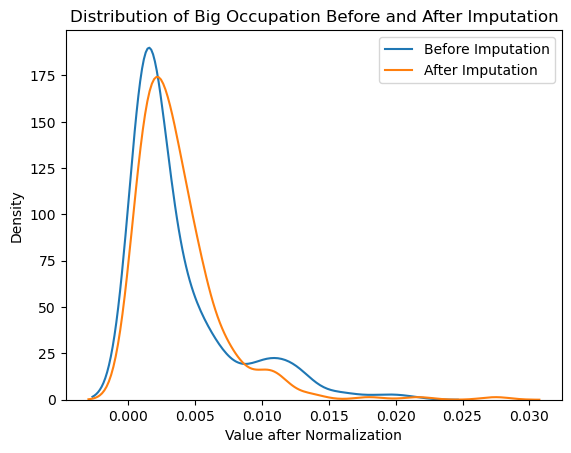

In [68]:
sns.kdeplot(ogdf['Big Days Acceptance to Match'].dropna().value_counts(normalize=True), label='Before Imputation')
sns.kdeplot( df_imputed['Big Days Acceptance to Match'].value_counts(normalize=True)
, label='After Imputation')

# Add labels and title
plt.xlabel('Value after Normalization')
plt.ylabel('Density')
plt.title('Distribution of Big Occupation Before and After Imputation')

# Add legend
plt.legend()

plt.show()

# Showing that the Data is MAR

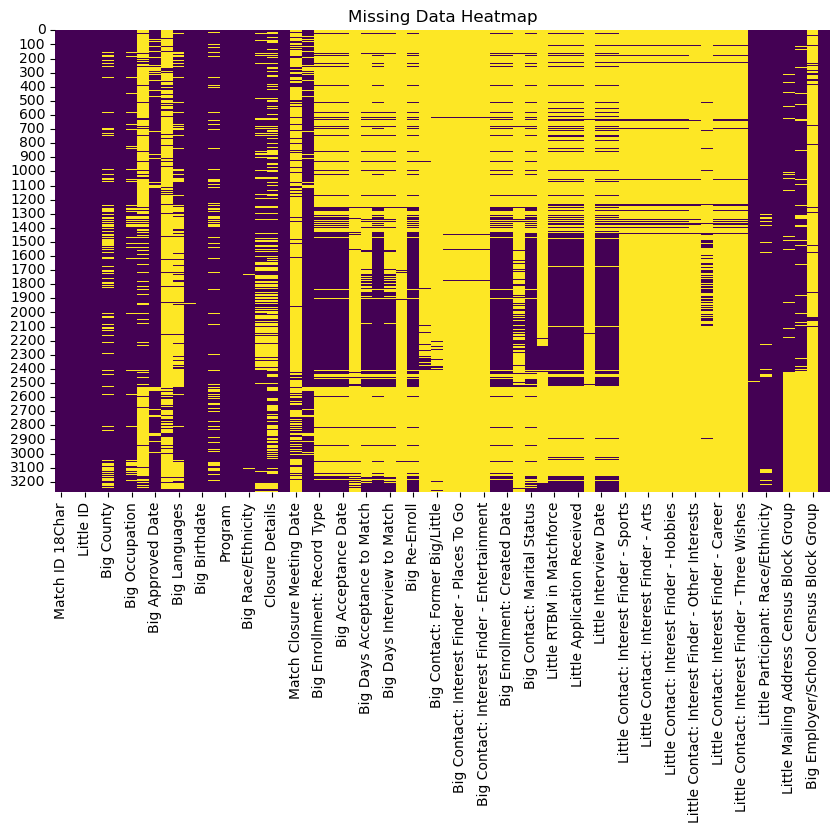

In [70]:
# Missing Heatmap
def plot_missing_heatmap(df):
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title('Missing Data Heatmap')
    plt.show()
    
plot_missing_heatmap(ogdf)

In [ ]:
# shadow matrix

def analyze_missingness_correlations(df):
    # Create a missing indicator DataFrame
    missing_indicator = df.isnull().astype(int)
    
    # Concatenate the original DataFrame with the missing indicator columns
    df_with_indicators = pd.concat([df, missing_indicator.add_suffix('_missing')], axis=1)
    
    # Select only numeric columns
    numeric_df = df_with_indicators.select_dtypes(include=['number'])
    
    # Calculate the correlation matrix for the numeric columns
    correlation_matrix = numeric_df.corr()
    
    # Print the correlation matrix of original data and missingness indicators
    print(correlation_matrix.iloc[:df.shape[1], df.shape[1]:])

analyze_missingness_correlations(ogdf)

                                                    Little Other Interests_missing  \
Big Age                                                                  -0.022395   
Big Days Acceptance to Match                                             -0.161849   
Big Days Interview to Acceptance                                          0.010836   
Big Days Interview to Match                                              -0.118340   
Big Re-Enroll                                                             0.040299   
...                                                                            ...   
Little Contact: Interest Finder - Arts_missing                            0.102368   
Little Contact: Interest Finder - Places To Go_...                        0.102368   
Little Contact: Interest Finder - Hobbies_missing                         0.102368   
Little Contact: Interest Finder - Entertainment...                        0.102368   
Little Contact: Interest Finder - Other Interes...    

In [76]:
#chi square test
from scipy.stats import chi2_contingency

def check_mcar_with_chi2(df):
    # Step 1: Create a missingness indicator DataFrame
    missing_indicator = df.isnull().astype(int)
    
    # Step 2: Perform Chi-square tests for pairs of columns to check independence
    # We will compare each pair of columns for independence of missingness
    columns = missing_indicator.columns
    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            col1, col2 = columns[i], columns[j]
            contingency_table = pd.crosstab(missing_indicator[col1], missing_indicator[col2])
            
            # Step 3: Apply Chi-square test
            chi2, p_value, _, _ = chi2_contingency(contingency_table)
            
            # Output the result of the test for this pair
            print(f"Chi-square test for missingness between '{col1}' and '{col2}':")
            print(f"Chi2: {chi2}, p-value: {p_value}")
            
            # Interpret the p-value (e.g., if p-value > 0.05, we cannot reject the null hypothesis)
            if p_value > 0.05:
                print(f"The missingness between '{col1}' and '{col2}' is independent (possibly MCAR).\n")
            else:
                print(f"The missingness between '{col1}' and '{col2}' is dependent (not MCAR).\n")

# Example: Call the function on your DataFrame
check_mcar_with_chi2(ogdf)

Chi-square test for missingness between 'Match ID 18Char' and 'Stage':
Chi2: 0.0, p-value: 1.0
The missingness between 'Match ID 18Char' and 'Stage' is independent (possibly MCAR).

Chi-square test for missingness between 'Match ID 18Char' and 'Little ID':
Chi2: 0.0, p-value: 1.0
The missingness between 'Match ID 18Char' and 'Little ID' is independent (possibly MCAR).

Chi-square test for missingness between 'Match ID 18Char' and 'Big ID':
Chi2: 0.0, p-value: 1.0
The missingness between 'Match ID 18Char' and 'Big ID' is independent (possibly MCAR).

Chi-square test for missingness between 'Match ID 18Char' and 'Big County':
Chi2: 0.0, p-value: 1.0
The missingness between 'Match ID 18Char' and 'Big County' is independent (possibly MCAR).

Chi-square test for missingness between 'Match ID 18Char' and 'Big Age':
Chi2: 0.0, p-value: 1.0
The missingness between 'Match ID 18Char' and 'Big Age' is independent (possibly MCAR).

Chi-square test for missingness between 'Match ID 18Char' and 'Big

# Merge Imputed Novice Data Set with Training set and create Imputed_Train

Brief Note: Still considering adding Match End Date, Little Age, Little County, and Big County

Create Imputed Novice Data

In [39]:
df_imputed.to_csv("../../data/Imputed_Novice.csv", index=False)

Merge Imputed dataset with Novice set

In [40]:
ogtrain= pd.read_excel("../../data/Training.xlsx")


In [41]:
train=ogtrain.copy()
train_impute=df_imputed.copy()

# Duplicate rows based on match ID
train_impute['matchIDcounts'] = train_impute['Match ID 18Char'].map(train['Match ID 18Char'].value_counts())

train_impute=train_impute.reindex(train_impute.index.repeat(train_impute.matchIDcounts+1))

train_impute.reset_index(drop=True, inplace=True)
#Remove all features in train except completion Date and Match support contact notes
train_impute['Completion Date']=train['Completion Date']
train_impute['Match Support Contact Notes']=train['Match Support Contact Notes']


# result=pd.concat([df1, df4], axis=1).reindex(df1.index)
#reorder
train_impute=train_impute.reindex(columns=['Match ID 18Char','Completion Date','Match Support Contact Notes','Stage','Little ID','Big ID','Big Age','Big Occupation','Big Languages','Big Gender',
                               'Big Birthdate', 'Program','Program Type','Big Race/Ethnicity','Closure Reason','Match Activation Date','Rationale for Match',
                               'Big Days Acceptance to Match','Big Days Interview to Acceptance','Big Days Interview to Match','Big Contact: Marital Status',
                               'Little Gender','Little Birthdate','Little Participant: Race/Ethnicity','Match Length'])
train_impute.head(20)


,Match ID 18Char,Completion Date,Match Support Contact Notes,Stage,Little ID,Big ID,Big Age,Big Occupation,Big Languages,Big Gender,Big Birthdate,Program,Program Type,Big Race/Ethnicity,Closure Reason,Match Activation Date,Rationale for Match,Big Days Acceptance to Match,Big Days Interview to Acceptance,Big Days Interview to Match,Big Contact: Marital Status,Little Gender,Little Birthdate,Little Participant: Race/Ethnicity,Match Length
0,a1v2J0000028pRvQAI,2017-11-30,Question: Activities: Answer: See ms...,Closed,0032J00003PLe29QAD,0032J00003PhDOI,40,Unemployed,No Preference,Female,1985-02-01,General Community,Community,Black or African American;White or Caucasian;,Volunteer: Health,2017-03-03,Not Specified,587.0,31.0,147.0,Married,Female,2004-01-01,Black or African American,9.0
1,a1v2J0000028pRvQAI,2017-10-31,Question: Activities: Answer: See MS...,Closed,0032J00003PLe29QAD,0032J00003PhDOI,40,Unemployed,No Preference,Female,1985-02-01,General Community,Community,Black or African American;White or Caucasian;,Volunteer: Health,2017-03-03,Not Specified,587.0,31.0,147.0,Married,Female,2004-01-01,Black or African American,9.0
2,a1v2J0000028pRvQAI,2017-12-01,Question: Activities: Answer: Match ...,Closed,0032J00003PLe29QAD,0032J00003PhDOI,40,Unemployed,No Preference,Female,1985-02-01,General Community,Community,Black or African American;White or Caucasian;,Volunteer: Health,2017-03-03,Not Specified,587.0,31.0,147.0,Married,Female,2004-01-01,Black or African American,9.0
3,a1v2J0000028pRvQAI,2017-05-29,Question: Activities: Answer: Msc as...,Closed,0032J00003PLe29QAD,0032J00003PhDOI,40,Unemployed,No Preference,Female,1985-02-01,General Community,Community,Black or African American;White or Caucasian;,Volunteer: Health,2017-03-03,Not Specified,587.0,31.0,147.0,Married,Female,2004-01-01,Black or African American,9.0
4,a1v2J0000028pRvQAI,2017-04-30,Question: Activities: Answer: Msc as...,Closed,0032J00003PLe29QAD,0032J00003PhDOI,40,Unemployed,No Preference,Female,1985-02-01,General Community,Community,Black or African American;White or Caucasian;,Volunteer: Health,2017-03-03,Not Specified,587.0,31.0,147.0,Married,Female,2004-01-01,Black or African American,9.0
5,a1v2J0000028pRvQAI,2017-06-30,Question: Activities: Answer: Msc as...,Closed,0032J00003PLe29QAD,0032J00003PhDOI,40,Unemployed,No Preference,Female,1985-02-01,General Community,Community,Black or African American;White or Caucasian;,Volunteer: Health,2017-03-03,Not Specified,587.0,31.0,147.0,Married,Female,2004-01-01,Black or African American,9.0
6,a1v2J0000028pRvQAI,2017-07-31,Question: Activities: Answer: BBBS S...,Closed,0032J00003PLe29QAD,0032J00003PhDOI,40,Unemployed,No Preference,Female,1985-02-01,General Community,Community,Black or African American;White or Caucasian;,Volunteer: Health,2017-03-03,Not Specified,587.0,31.0,147.0,Married,Female,2004-01-01,Black or African American,9.0
7,a1v2J0000028pRvQAI,2017-03-30,Question: Activities: Answer: Msc as...,Closed,0032J00003PLe29QAD,0032J00003PhDOI,40,Unemployed,No Preference,Female,1985-02-01,General Community,Community,Black or African American;White or Caucasian;,Volunteer: Health,2017-03-03,Not Specified,587.0,31.0,147.0,Married,Female,2004-01-01,Black or African American,9.0
8,a1v2J0000028pRvQAI,2017-10-11,Question: Activities: Answer: Msc as...,Closed,0032J00003PLe29QAD,0032J00003PhDOI,40,Unemployed,No Preference,Female,1985-02-01,General Community,Community,Black or African American;White or Caucasian;,Volunteer: Health,2017-03-03,Not Specified,587.0,31.0,147.0,Married,Female,2004-01-01,Black or African American,9.0
9,a1v2J0000028pRvQAI,2017-12-01,NaN,Closed,0032J00003PLe29QAD,0032J00003PhDOI,40,Unemployed,No Preference,Female,1985-02-01,General Community,Community,Black or African American;White or Caucasian;,Volunteer: Health,2017-03-03,Not Specified,587.0,31.0,147.0,Married,Female,2004-01-01,Black or African American,9.0


In [42]:
#create csv file with Imputed_Training data
train_impute.to_csv("../../data/Imputed_Training.csv", index=False)